In [1]:
import heeps
from heeps.pupil import pupil
from heeps.optics import apodizer, fp_mask, lyot_stop
from heeps.util.img_processing import pad_img
from heeps.wavefront.get_array import show_wf
import proper
from copy import deepcopy
import numpy as np
import pyfftw.interfaces.numpy_fft as fftw
%pylab
%matplotlib inline

Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


## before Lyot-stop

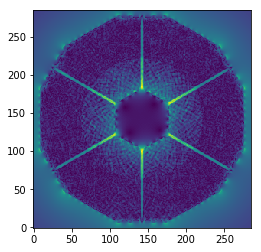

In [2]:
focal = 658.6
ngrid = 1024
npupil = 285
ndet = 253
wf = pupil(file_pupil='/Users/cdelacroix/dox/METIS/METIS_HCI_HEEPS_simulations/PUPIL/ELT_fullM1.fits')
phase_screen = fits.getdata('/Users/cdelacroix/INSTRUMENTS/METIS/heeps_analysis/input_files/WFerrors/cube_Cbasic_20201130_3600s_300ms_0piston_meters_all_ncpa_285.fits')[0]
proper.prop_add_phase(wf, pad_img(phase_screen, ngrid))
wf = apodizer(wf)
wf = fp_mask(wf)
amp_before = show_wf(wf, 'amp', npupil)


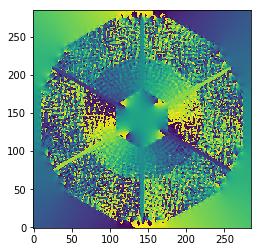

In [3]:
phi_before = show_wf(wf, 'phi', npupil)

## after lyot stop

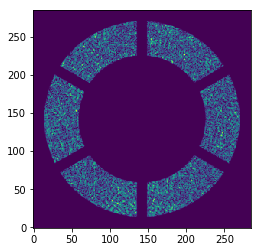

In [4]:
wf = lyot_stop(wf, file_lyot_stop='/Users/cdelacroix/dox/METIS/METIS_HCI_HEEPS_simulations/PUPIL/ls_ravc_circ_285.fits')
amp_after = show_wf(wf, 'amp', npupil)

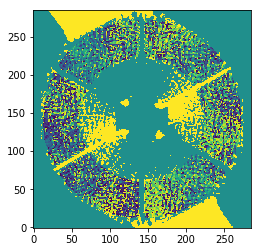

In [5]:
phi_after = show_wf(wf, 'phi', npupil)

# Let's see how fast we can get an image at the detector plane using FFT

In [6]:
# detector funtion
def detector(wf, ngrid=ngrid, ndet=ndet):
    (psf, _) = proper.prop_end(wf, NOABS = False)
    start = int(ngrid/2 - ndet/2) + 1
    end = int(ngrid/2 + ndet/2) + 1
    psf = psf[start:end, start:end]
    return psf

## benchmark

In [7]:
# current HEEPS, using PROPER
def test1():
    wf1 = deepcopy(wf)
    proper.prop_propagate(wf1, focal)
    proper.prop_lens(wf1, focal)
    proper.prop_propagate(wf1, focal)
    return detector(wf1)
print('PROPER', end=': ')
%timeit(test1())

# using NumPy
def test2():
    wf1 = deepcopy(wf)
    proper.prop_propagate(wf1, focal)
    wf1._wfarr = np.fft.fft2(wf1._wfarr)/wf1._ngrid # <-- this line has changed
    proper.prop_propagate(wf1, focal)
    return detector(wf1)
print('NumPy', end=': ')
%timeit(test2())

# using pyFFTW
def test3():
    wf1 = deepcopy(wf)
    proper.prop_propagate(wf1, focal)
    wf1._wfarr = fftw.fft2(wf1._wfarr)/wf1._ngrid # <-- this line has changed
    proper.prop_propagate(wf1, focal)
    return detector(wf1)
print('pyFFTW', end=': ')
%timeit(test3())

PROPER: 329 ms ± 19.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
NumPy: 267 ms ± 12.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
pyFFTW: 297 ms ± 14.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## PSF with PROPER

0.0033865722101190997

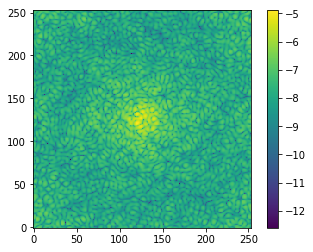

In [8]:
imshow(np.log10(test1()), origin=True);colorbar()
np.sum(test1())

## compare PSFs with NumPy

PSF_test1 / PSF_test2 = 1.0000010788991707
'All close' = True


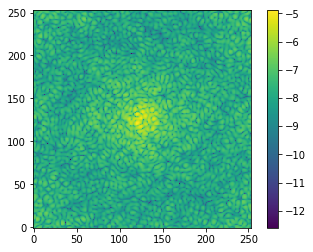

In [9]:
imshow(np.log10(test2()), origin=True); colorbar()
print('PSF_test1 / PSF_test2 = %s'%(np.sum(test1())/np.sum(test2())))
print("'All close' = %s"%np.allclose(test1(), test2()))

## compare PSFs with pyFFTW

PSF_test1 / PSF_test3 = 1.0000010788991707
'All close' = True


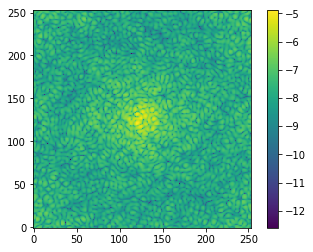

In [10]:
imshow(np.log10(test3()), origin=True);colorbar()
print('PSF_test1 / PSF_test3 = %s'%(np.sum(test1())/np.sum(test3())))
print("'All close' = %s"%np.allclose(test1(), test3()))

In [11]:
import inspect
print(inspect.getsource(proper.prop_lens))

def prop_lens(wf, lens_fl, surface_name = ""):
    """Alter the current wavefront as a perfect lens would. 
    
    This routine computes the phase change cause by a perfect lens that has a 
    focal length specified by the user. A positive focal length corresponds to 
    a convex lens or concave mirror; a negative length corresponds to a concave 
    lens or convex mirror. This routine updates the new beam waist position.
    
    Parameters
    ----------
    wf : obj
        WaveFront class object
        
    lens_fl : float
        Focal length of lens in meters
        
    surface_name : str
        String containing name of surface; used when printing out that a lens 
        is being applied
        
    Returns
    -------
        None
        Modifies wavefront array in wf object.
    """
    rayleigh_factor = proper.rayleigh_factor
    
    if proper.print_it:
        if surface_name == "":
            print( "Applying lens" ) 
        else:
            print( "Applying 